In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import os
import os.path as osp
from sklearn.metrics import roc_auc_score, average_precision_score
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
import torch
import torch.nn.functional as F

from tqdm import tqdm

from torch_geometric.loader import NeighborSampler
from torch_geometric.nn import SAGEConv
from torch.nn import Linear
from typing import Tuple, Union

import torch.nn.functional as F
from torch import Tensor
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size
import torch.utils.data as data_utils

/data/han/miniconda3/envs/torch190_geo204/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_name = "ogbn-products"
dataset_dir = "/data/han/mlpinit"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root = osp.join( dataset_dir, dataset_name)

dataset = PygNodePropPredDataset(dataset_name, root)
split_idx = dataset.get_idx_split()
evaluator = Evaluator(name=dataset_name)
data = dataset[0]
train_idx = split_idx['train']

X_train = data.x[ split_idx["train"] ]
y_train = data.y[ split_idx["train"] ].reshape(-1).type(torch.long)


x = data.x
y = data.y.squeeze()



print( "data.x.shape:", data.x.shape )
print( "data.y.shape:", data.y.shape )
print( "data.x.type:", x.dtype )
print( "data.y.type:", y.dtype )
print( "X_train.shape:", X_train.shape )
print( "y_train.shape:", y_train.shape )


y = data.y.squeeze().type(torch.long)
print( "data.y.type:", y.dtype )


X_y_train_mlpinit = data_utils.TensorDataset(X_train, y_train)
X_y_all_mlpinit = data_utils.TensorDataset(x, y)

train_mlpinit_loader = data_utils.DataLoader(X_y_train_mlpinit, batch_size=4096, shuffle=True, num_workers=4)
all_mlpinit_loader = data_utils.DataLoader(X_y_all_mlpinit, batch_size=4096, shuffle=False, num_workers=4)


class SAGEConv_like_MLP(torch.nn.Module):
   
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, normalize: bool = False,
                 root_weight: bool = True, bias: bool = True, **kwargs):
        # kwargs.setdefault('aggr', 'mean')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = Linear(in_channels[0], out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor]) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        out = x[1]
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out



class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv_like_MLP(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv_like_MLP(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv_like_MLP(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x):
        for i in range(self.num_layers):
            x_target = x
            x = self.convs[i]((x, x_target))
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1)




class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.num_layers = num_layers

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adjs):
        # `train_loader` computes the k-hop neighborhood of a batch of nodes,
        # and returns, for each layer, a bipartite graph object, holding the
        # bipartite edges `edge_index`, the index `e_id` of the original edges,
        # and the size/shape `size` of the bipartite graph.
        # Target nodes are also included in the source nodes so that one can
        # easily apply skip-connections or add self-loops.
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x.log_softmax(dim=-1)



    def inference(self, x_all):
        pbar = tqdm(total=x_all.size(0) * self.num_layers)
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch.
        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = F.relu(x)
                xs.append(x.cpu())

                pbar.update(batch_size)

            x_all = torch.cat(xs, dim=0)

        pbar.close()

        return x_all



model_mlpinit = MLP(dataset.num_features, 512, dataset.num_classes, num_layers=4)
model_mlpinit = model_mlpinit.to(device)
optimizer_model_mlpinit = torch.optim.Adam(model_mlpinit.parameters(), lr=0.001, weight_decay = 0.0)



data.x.shape: torch.Size([2449029, 100])
data.y.shape: torch.Size([2449029, 1])
data.x.type: torch.float32
data.y.type: torch.int64
X_train.shape: torch.Size([196615, 100])
y_train.shape: torch.Size([196615])
data.y.type: torch.int64


In [4]:
def train_mlpinit():
    model_mlpinit.train()
    total_loss = total_correct = 0

    for x, y in train_mlpinit_loader:

        x = x.to( device )
        y = y.to( device )

        optimizer_model_mlpinit.zero_grad()
        out = model_mlpinit(x)
        loss = F.nll_loss(out, y)
        loss.backward()
        optimizer_model_mlpinit.step()

        total_loss += float(loss)

    loss = total_loss / len(train_mlpinit_loader)
    approx_acc = total_correct / train_idx.size(0)

    return loss, approx_acc


@torch.no_grad()
def test_mlpinit():
    model_mlpinit.eval()

    out_list = []
    y_list = []

    for x, y in  all_mlpinit_loader:
        x = x.to( device )
        y = y.to( device )
        out = model_mlpinit(x)
        out_list.append( out )
        y_list.append( y )


    out = torch.cat(out_list, dim=0)
    y_true = torch.cat(y_list, dim=0).cpu().unsqueeze(-1)


    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    val_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, val_acc, test_acc



train_loader = NeighborSampler(data.edge_index, node_idx=train_idx,
                               sizes=[25, 10, 5, 5], batch_size=1024,
                               shuffle=True, num_workers=12)
subgraph_loader = NeighborSampler(data.edge_index, node_idx=None, sizes=[-1],
                                  batch_size=4096, shuffle=False,
                                  num_workers=12)


model = SAGE(dataset.num_features, 512, dataset.num_classes, num_layers=4)
model = model.to(device)



def train(epoch):
    model.train()

    pbar = tqdm(total=train_idx.size(0))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = 0

    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]

        optimizer.zero_grad()

        out = model(x[n_id].to(device), adjs)
        loss = F.nll_loss( out, y[n_id[:batch_size]].to(device) )
        loss.backward()
        optimizer.step()

        total_loss += float(loss)
        total_correct += int(out.argmax(dim=-1).eq( y[n_id[:batch_size]].to(device) ).sum())
        pbar.update(batch_size)

    pbar.close()

    loss = total_loss / len(train_loader)
    approx_acc = total_correct / train_idx.size(0)

    return loss, approx_acc




@torch.no_grad()
def test():
    model.eval()

    out = model.inference(x)

    y_true = y.cpu().unsqueeze(-1)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    val_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, val_acc, test_acc




In [5]:
random_losses = []
random_test_accs = []

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0)

best_val_acc = final_test_acc = 0
for epoch in range(1, 21):
    loss, acc = train(epoch)
    train_acc, val_acc, test_acc = test()
    print(f'Epoch {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, 'f'Test: {test_acc:.4f}')
    
    random_losses.append(loss)
    random_test_accs.append(test_acc)

Evaluating: 100%|██████████| 9796116/9796116 [02:53<00:00, 56523.84it/s] 


Epoch 01, Train: 0.8784, Val: 0.8723, Test: 0.7087


Evaluating: 100%|██████████| 9796116/9796116 [02:59<00:00, 54590.62it/s] 


Epoch 02, Train: 0.8974, Val: 0.8933, Test: 0.7504


Evaluating: 100%|██████████| 9796116/9796116 [02:52<00:00, 56726.35it/s] 


Epoch 03, Train: 0.9155, Val: 0.9066, Test: 0.7638


Evaluating: 100%|██████████| 9796116/9796116 [02:57<00:00, 55282.10it/s] 


Epoch 04, Train: 0.9118, Val: 0.9056, Test: 0.7777


Evaluating: 100%|██████████| 9796116/9796116 [02:48<00:00, 58130.96it/s] 


Epoch 05, Train: 0.9244, Val: 0.9148, Test: 0.7963


Evaluating: 100%|██████████| 9796116/9796116 [02:59<00:00, 54566.47it/s] 


Epoch 06, Train: 0.9171, Val: 0.9066, Test: 0.7869


Evaluating: 100%|██████████| 9796116/9796116 [02:52<00:00, 56882.42it/s] 


Epoch 07, Train: 0.9196, Val: 0.9104, Test: 0.7766


Evaluating: 100%|██████████| 9796116/9796116 [02:56<00:00, 55524.60it/s] 


Epoch 08, Train: 0.9242, Val: 0.9116, Test: 0.7891


Evaluating: 100%|██████████| 9796116/9796116 [03:05<00:00, 52761.20it/s] 


Epoch 09, Train: 0.9292, Val: 0.9191, Test: 0.7985


Evaluating: 100%|██████████| 9796116/9796116 [03:00<00:00, 54274.18it/s] 


Epoch 10, Train: 0.9285, Val: 0.9138, Test: 0.8026


Evaluating: 100%|██████████| 9796116/9796116 [03:01<00:00, 54092.61it/s] 


Epoch 11, Train: 0.9250, Val: 0.9105, Test: 0.7963


Evaluating: 100%|██████████| 9796116/9796116 [02:56<00:00, 55489.05it/s] 


Epoch 12, Train: 0.9344, Val: 0.9170, Test: 0.7900


Evaluating: 100%|██████████| 9796116/9796116 [02:58<00:00, 55011.76it/s] 


Epoch 13, Train: 0.9380, Val: 0.9236, Test: 0.8037


Evaluating: 100%|██████████| 9796116/9796116 [03:17<00:00, 49701.86it/s]


Epoch 14, Train: 0.9397, Val: 0.9239, Test: 0.8042


Evaluating: 100%|██████████| 9796116/9796116 [03:10<00:00, 51496.22it/s] 


Epoch 15, Train: 0.9284, Val: 0.9134, Test: 0.7953


Evaluating: 100%|██████████| 9796116/9796116 [02:56<00:00, 55655.17it/s] 


Epoch 16, Train: 0.9415, Val: 0.9228, Test: 0.8065


Evaluating: 100%|██████████| 9796116/9796116 [03:16<00:00, 49972.95it/s] 


Epoch 17, Train: 0.9344, Val: 0.9180, Test: 0.7988


Evaluating: 100%|██████████| 9796116/9796116 [03:05<00:00, 52801.84it/s] 


Epoch 18, Train: 0.9414, Val: 0.9236, Test: 0.8124


Evaluating: 100%|██████████| 9796116/9796116 [03:07<00:00, 52278.33it/s] 


Epoch 19, Train: 0.9434, Val: 0.9257, Test: 0.8062


Evaluating: 100%|██████████| 9796116/9796116 [03:22<00:00, 48440.16it/s] 


Epoch 20, Train: 0.9172, Val: 0.8946, Test: 0.7768


In [6]:
model_mlpinit.reset_parameters()

for epoch in range(1, 20):
    loss, acc = train_mlpinit()
    
torch.save(model_mlpinit.state_dict(), f'./model_mlpinit.pt' )
train_acc_init, val_acc_init, test_acc_init = test_mlpinit()
print(  "train_acc_init, val_acc_init, test_acc_init:", train_acc_init, val_acc_init, test_acc_init )


train_acc_init, val_acc_init, test_acc_init: 0.7768684993515246 0.7464079546321492 0.6032065558985148


In [7]:
mlpinit_losses = []
mlpinit_test_accs = []

model.load_state_dict(torch.load( f'./model_mlpinit.pt'  ))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0)

best_val_acc = final_test_acc = 0
for epoch in range(1, 21):
    loss, acc = train(epoch)
    train_acc, val_acc, test_acc = test()
    print(f'Epoch {epoch:02d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, 'f'Test: {test_acc:.4f}')
    
    mlpinit_losses.append(loss)
    mlpinit_test_accs.append(test_acc)


Evaluating: 100%|██████████| 9796116/9796116 [02:59<00:00, 54631.37it/s] 


Epoch 01, Train: 0.9170, Val: 0.9075, Test: 0.7771


Evaluating: 100%|██████████| 9796116/9796116 [03:03<00:00, 53421.86it/s] 


Epoch 02, Train: 0.9240, Val: 0.9122, Test: 0.7858


Evaluating: 100%|██████████| 9796116/9796116 [02:53<00:00, 56556.11it/s] 


Epoch 03, Train: 0.9303, Val: 0.9173, Test: 0.7967


Evaluating: 100%|██████████| 9796116/9796116 [02:59<00:00, 54456.88it/s] 


Epoch 04, Train: 0.9328, Val: 0.9187, Test: 0.7993


Evaluating: 100%|██████████| 9796116/9796116 [02:52<00:00, 56741.49it/s] 


Epoch 05, Train: 0.9316, Val: 0.9187, Test: 0.7950


Evaluating: 100%|██████████| 9796116/9796116 [02:57<00:00, 55261.36it/s] 


Epoch 06, Train: 0.9342, Val: 0.9210, Test: 0.7995


Evaluating: 100%|██████████| 9796116/9796116 [02:57<00:00, 55204.87it/s] 


Epoch 07, Train: 0.9395, Val: 0.9225, Test: 0.8026


Evaluating: 100%|██████████| 9796116/9796116 [02:55<00:00, 55740.37it/s] 


Epoch 08, Train: 0.9395, Val: 0.9226, Test: 0.7996


Evaluating: 100%|██████████| 9796116/9796116 [02:53<00:00, 56433.61it/s] 


Epoch 09, Train: 0.9415, Val: 0.9233, Test: 0.8052


Evaluating: 100%|██████████| 9796116/9796116 [03:03<00:00, 53525.82it/s] 


Epoch 10, Train: 0.9420, Val: 0.9227, Test: 0.8096


Evaluating: 100%|██████████| 9796116/9796116 [02:43<00:00, 59794.66it/s] 


Epoch 11, Train: 0.9428, Val: 0.9232, Test: 0.8030


Evaluating: 100%|██████████| 9796116/9796116 [03:11<00:00, 51022.47it/s] 


Epoch 12, Train: 0.9358, Val: 0.9182, Test: 0.8058


Evaluating: 100%|██████████| 9796116/9796116 [02:55<00:00, 55916.25it/s] 


Epoch 13, Train: 0.9442, Val: 0.9252, Test: 0.8004


Evaluating: 100%|██████████| 9796116/9796116 [03:04<00:00, 53137.93it/s] 


Epoch 14, Train: 0.9405, Val: 0.9199, Test: 0.7950


Evaluating: 100%|██████████| 9796116/9796116 [03:00<00:00, 54348.72it/s] 


Epoch 15, Train: 0.9455, Val: 0.9257, Test: 0.7998


Evaluating: 100%|██████████| 9796116/9796116 [03:12<00:00, 50844.19it/s] 


Epoch 16, Train: 0.9473, Val: 0.9264, Test: 0.8053


Evaluating: 100%|██████████| 9796116/9796116 [02:53<00:00, 56499.60it/s] 


Epoch 17, Train: 0.9464, Val: 0.9252, Test: 0.8066


Evaluating: 100%|██████████| 9796116/9796116 [02:52<00:00, 56785.00it/s] 


Epoch 18, Train: 0.9467, Val: 0.9251, Test: 0.8010


Evaluating: 100%|██████████| 9796116/9796116 [03:02<00:00, 53705.21it/s] 


Epoch 19, Train: 0.9494, Val: 0.9264, Test: 0.8066


Evaluating: 100%|██████████| 9796116/9796116 [03:04<00:00, 53114.72it/s] 


Epoch 20, Train: 0.9456, Val: 0.9252, Test: 0.8020


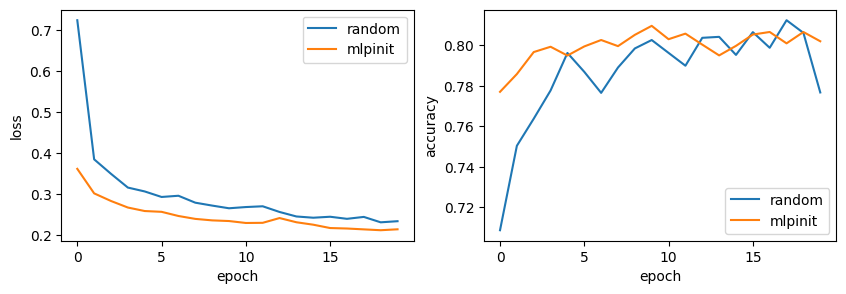

In [8]:
import matplotlib.pyplot as plt

x=range( 0, 20 )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x, random_losses, label='random')
ax1.plot(x, mlpinit_losses, label='mlpinit')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(x, random_test_accs, label='random')
ax2.plot(x, mlpinit_test_accs, label='mlpinit')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

plt.show()